# Model zur Klassifizierung von Flugobjekten
Autor: Tim Seidel

## Dieses "Convolutional Neural Network" (CNN) verwendet die "deep learning" Bibliothek namens fast.ai

- ImageDataLoaders Optimierungen: Fastai verwendet optimierte Datenpipelines, die Engpässe beim Laden und Vorverarbeiten von Bildern reduzieren.
- Parallelisiertes Laden von Daten: Es nutzt num_workers in DataLoader, um Bilder parallel zu laden und zu verarbeiten.
- Data Augmentations: "Augmentations" werden mithilfe von batch_tfms on-the-fly angewendet, so dass sie das Laden von Daten nicht verlangsamen.

#### Der folgende Code enthält alle nötigen Imports zur erfolgreichen Ausführung des Programs

In [28]:
from fastai import*
from fastai.vision.all import*
from fastai.vision.widgets import *
from pathlib import Path
import pathlib
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Die folgende Zeile enthält den Dateipfad

In [5]:
path = Path(r'/Users/timseidel/Documents/DataScience_SoftwareTesting/aircraftDataset/train') 

## Load and Preprocess Data
Die folgende Funktion ist sehr mächtig. Möglicherweise ist euch bewusst, dass Machine Learning Modelle Training sowie Validations Datensätze benötigen, um richtig zu funktionieren.  Bisher habt ihr dem Modell lediglich Trainings Daten gegeben, doch die Funktion funktioniert trotzdem. Wieso? 

Sie verwendet den Dateipfad und den darin enthaltenden Trainings Ordner, um einen Validations Datensatz anhand der "valid_pct" Zahl zu kreieren.

Außerdem verwendet die Funktion automatisch die Ordnernamen als "Labels" für die verschiedenen Bilder
- Was meine ich mit Labels?

### size = 450
Ändert die Größe aller Bilder auf 450 Pixel -> globale Einstellung (wirkt sich auf Trainings- und Testdaten aus). Standardisiert die Größen der Bilder. 
### num_workers = 0
Kein paralleles laden
### item_tfms
Schneidet zufällig eine 128x128 Pixel Region des Bildes aus welches mindestens 35% der ursprünglichen Bildgröße entspricht (verhindert übermäßiges Zoomen). Pro Epoche sieht das Model einen dieser Bildausschnitte. Der zufällige Ausschnitt wird bei jedem Durchlauf des Datensatzes dynamisch erzeugt.
Der beschnittene Bereich ändert sich jedes Mal, wenn das Bild geladen wird, so dass das Modell nie genau das gleiche Bild zweimal sieht.
- Was sind Epochen?
### batch_tfms
Normalisiert Bilder anhand von Mittelwert und Standardabweichung von ImageNet (Datenbank von Bilder -> findet bei Bildverarbeitung sehr oft Anwendung). Wird auf den gesamten Batch angewendet und nicht pro-Bild ausgeführt 

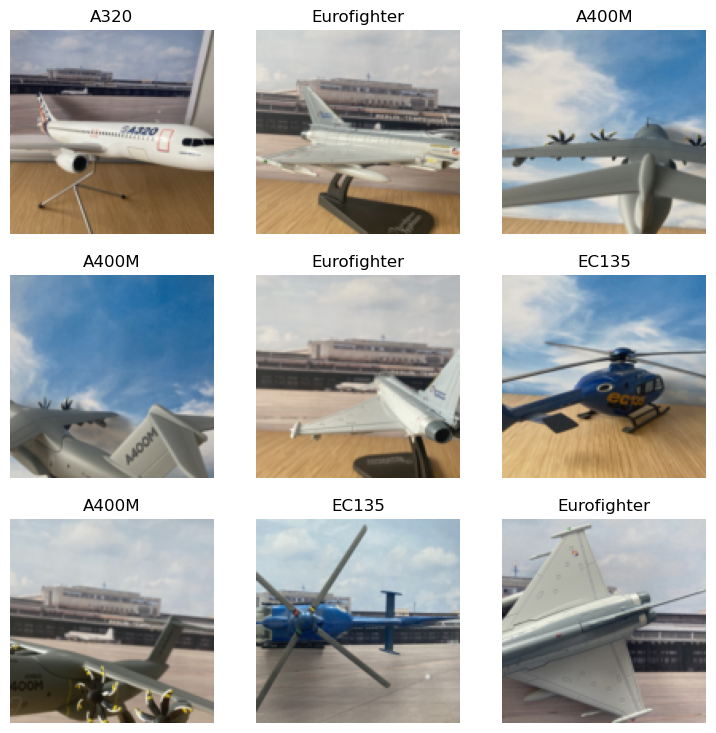

In [7]:
data = ImageDataLoaders.from_folder(path, train=".", valid_pct=0.2, size=450, num_workers=0, valid='val',
                                    item_tfms=RandomResizedCrop(128, min_scale=0.35),
                                    batch_tfms=Normalize.from_stats(*imagenet_stats))

data.show_batch() # Will output a set number of input data along with their labels

Die folgenden zwei len() Funktionen geben die Länge der Trainings- und Validationsdaten aus. Die Länge der Validationsdaten ist abhängig von der Zahl die dem valid_pct Parameter übergeben wird. 

In [9]:
len(data.train_ds), len(data.valid_ds)

(96, 24)

## Trainieren des Modells
Verwendet wird der "vision_learner". Ein geeignetes CNN für "Transfer Learning im Bereich der Computer Vision
Die Funktion verwendent den Datensatz der ImageDataLoaders.from_folder() Funktion, sowie das vortrainierte convulutional neural network (ResNet). ResNet besteht aus 50 vortrainierten Schichten. Transfer Learning ermöglicht uns viel schneller und effizienter zu trainieren 

Fragen: 
- Train-Loss fällt während, valid_loss steigt
- Was sind Epochen
- Trotz der 96 Trainingsbilder, sieht das Modell 576 -> wieso?
- Was ist Transfer Learning?

Train_loss > valid_loss bedeutet die "learning rate" und/oder the Anzahl Epochen ist zu niedrig 

- ResNet-18: 18 Schichten, ca. 11,7 millionen Parameter
- ResNet-50: 50 Schichten, ca. 25,6 millionen Parameter

In [12]:
learner_18 = vision_learner(data, models.resnet18, metrics=error_rate)
learner_50 = vision_learner(data, models.resnet50, metrics=error_rate)

In [14]:
learner_18.fit_one_cycle(6) # fits one cycle of 6 epochs and outputs the metrics, i.e. how well the model performs on your dataset

In [15]:
learner_50.fit_one_cycle(6)

Fragen
- Wieso ist learner_50 besser?

## Auswertung ResNet 18
Die folgende Zeile gibt eine Matrix von Bildern aus, die das Modell  am meisten verwirrt haben. 
Fragen: 
- Welche Bedeutung habe die Zahlen?

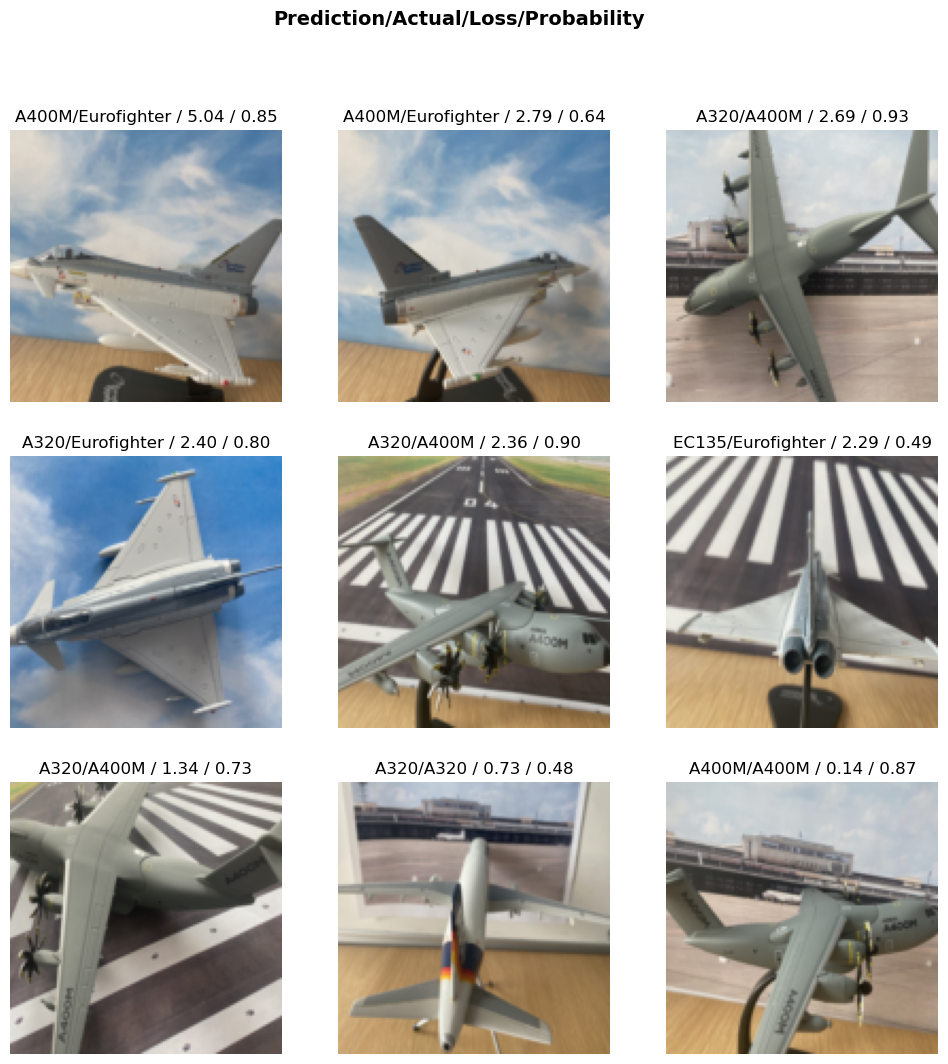

In [18]:
interp_18 = ClassificationInterpretation.from_learner(learner_18)
interp_18.plot_top_losses(9, figsize=(12,12))

Die folgende Zeile gibt eine "Confusion Matrix" aus. Die Diagonale entspricht den richtig geratenen Bildern und alles außerhalb der Diagonale wurde falsch erraten. Die zu erratenden Bilder ergeben sich aus dem "validation" set.

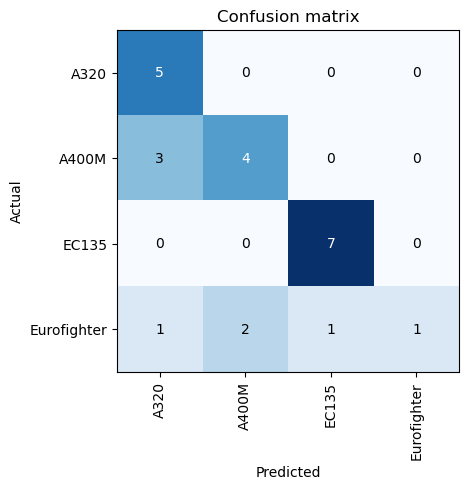

In [19]:
interp_18.plot_confusion_matrix()

## Auswertung ResNet 50

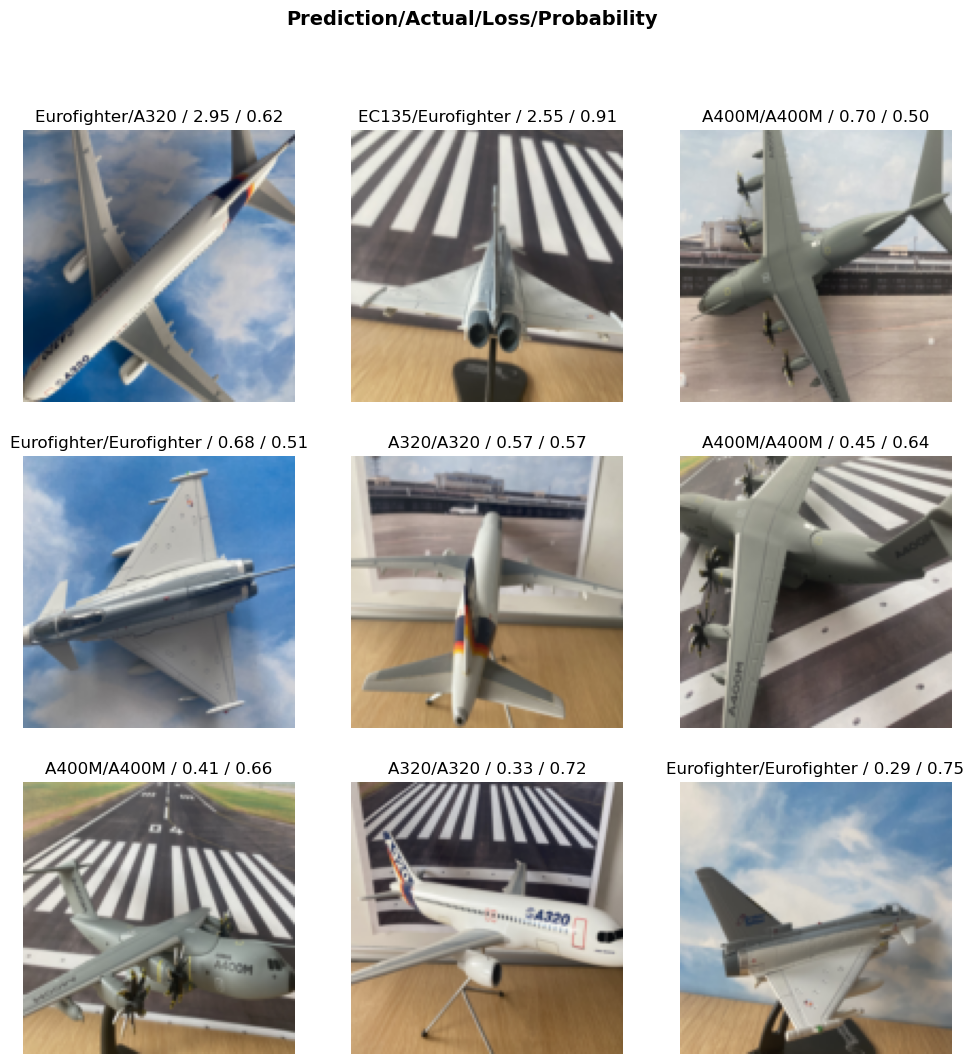

In [22]:
interp_50 = ClassificationInterpretation.from_learner(learner_50)
interp_50.plot_top_losses(9, figsize=(12,12))

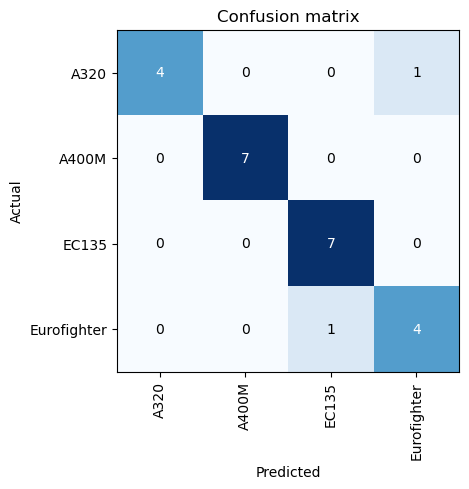

In [23]:
interp_50.plot_confusion_matrix()

## Anwendung auf neue Bilder

Is Correct? True



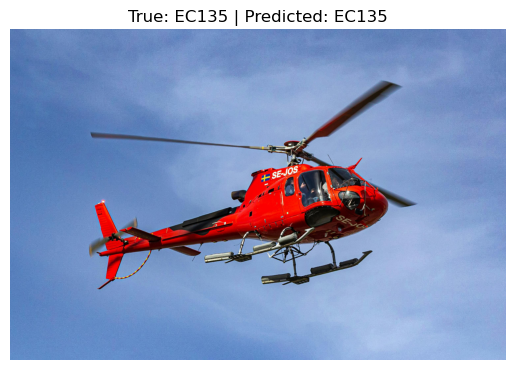

Is Correct? True



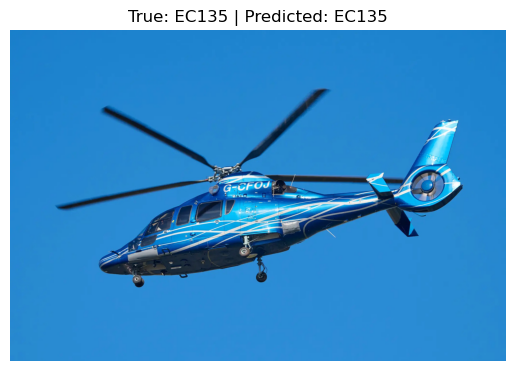

Is Correct? True



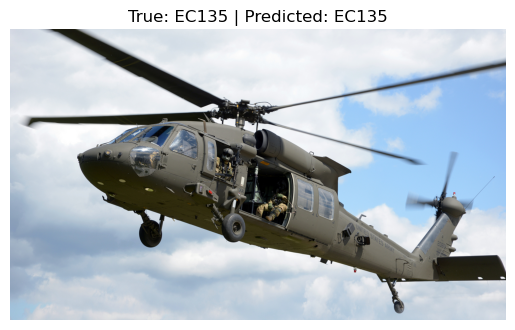

Is Correct? True



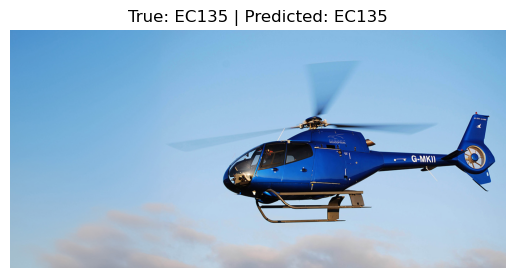

Is Correct? True



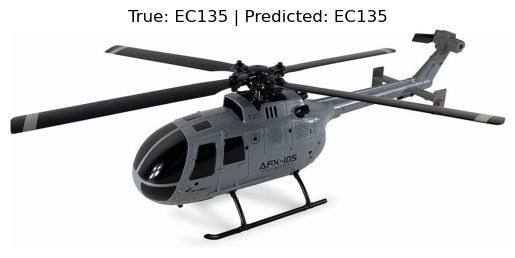

Is Correct? True



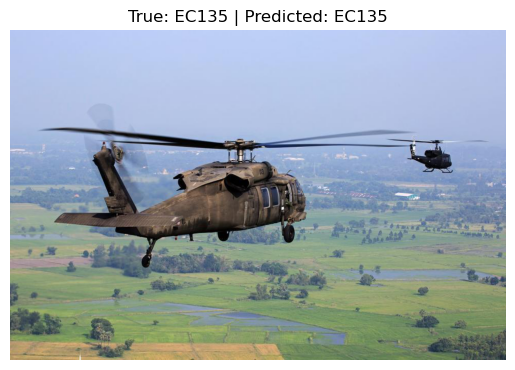

Is Correct? False



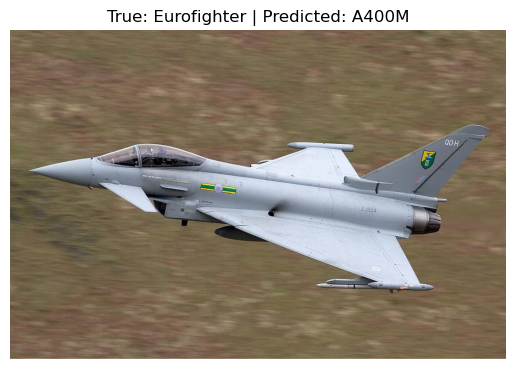

Is Correct? False



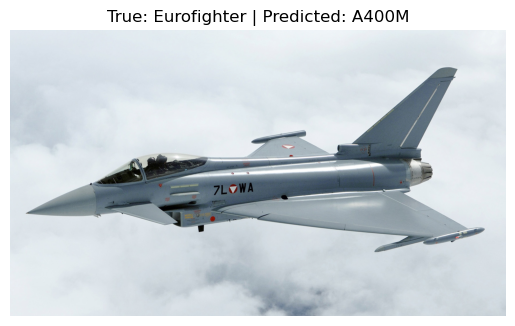

Is Correct? True



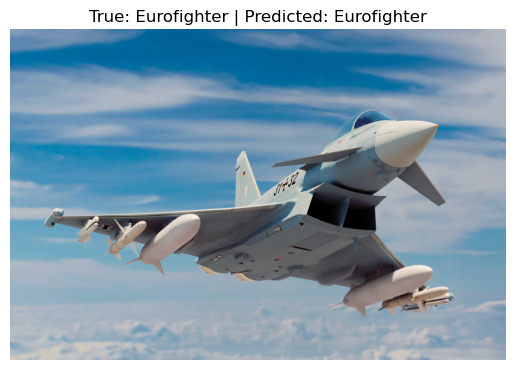

Is Correct? False



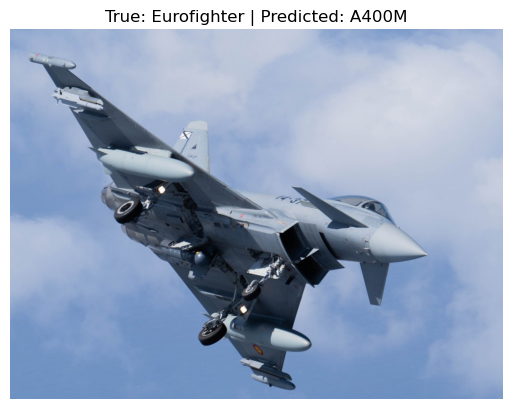

Is Correct? False



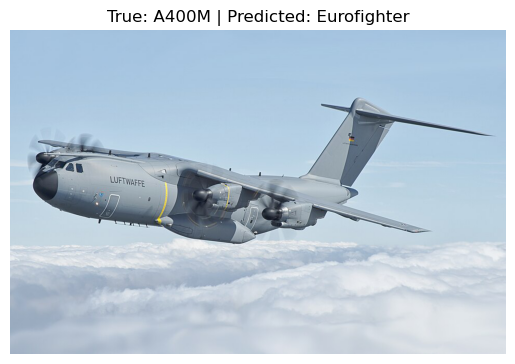

Is Correct? False



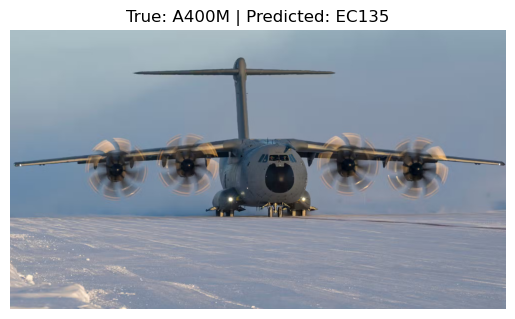

Is Correct? False



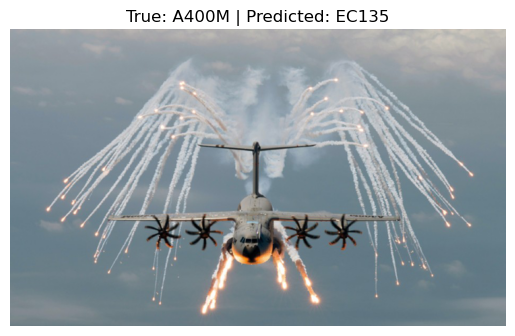

Is Correct? True



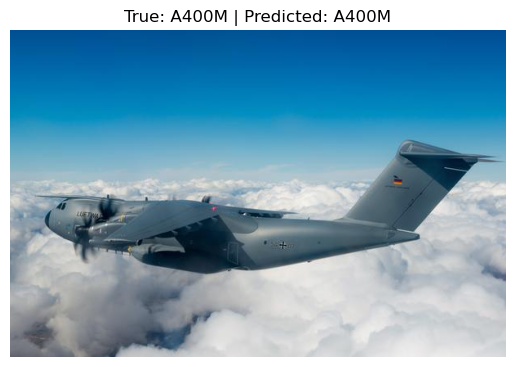

Is Correct? False



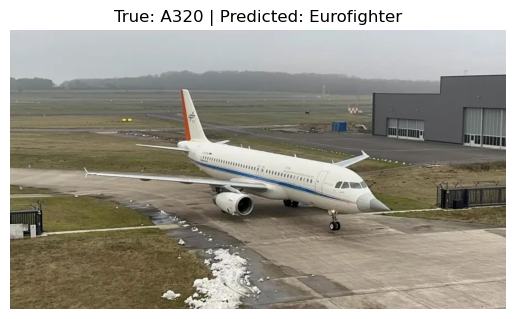

Is Correct? True



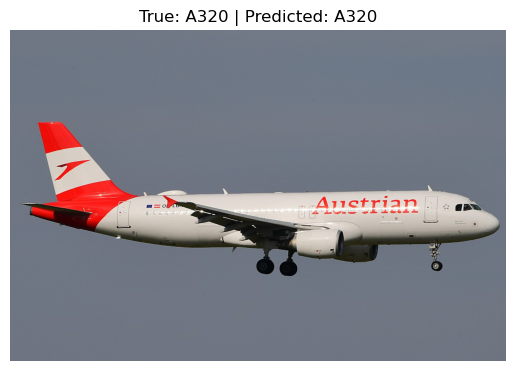

Is Correct? False



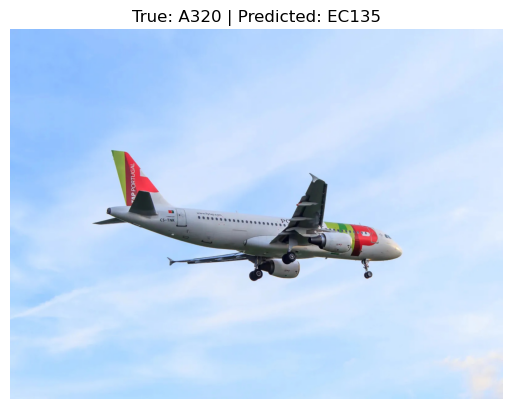

Is Correct? False



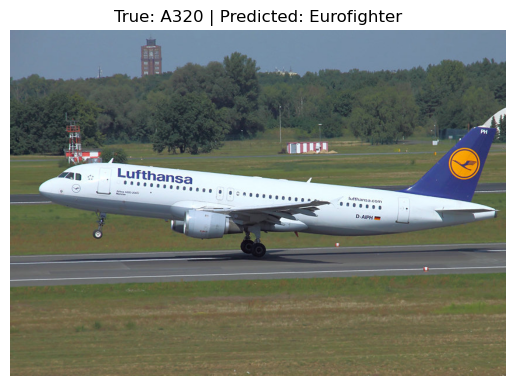

Is Correct? False



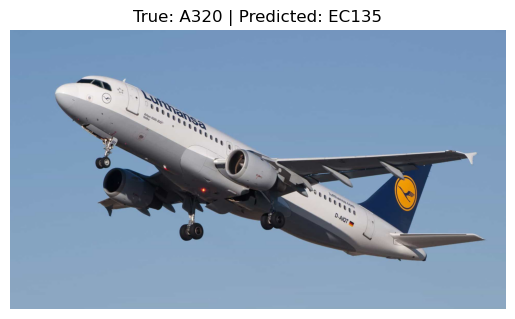

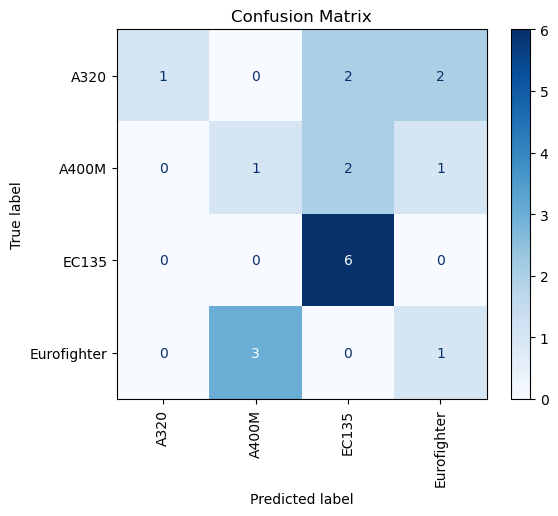


Final Accuracy: 47.37% (9/19)


In [38]:
# Path to the folder containing test images, structured by class
test_root = pathlib.Path("/Users/timseidel/Documents/DataScience_SoftwareTesting/aircraftDataset/test_folder")

# Track accuracy and predictions
true_labels = []
pred_labels = []
correct = 0
total = 0

# Get class names, excluding hidden folders like .ipynb_checkpoints
class_names = sorted([d.name for d in test_root.iterdir() if d.is_dir() and not d.name.startswith('.')])

# Loop through class folders
for class_folder in test_root.iterdir():
    if class_folder.is_dir() and not class_folder.name.startswith('.'):  # Ensure it's a valid class folder
        true_class = class_folder.name  # Ground truth label from folder name
        
        # Loop through all images in the folder
        for image_path in class_folder.iterdir():
            if image_path.suffix.lower() in ['.jpg', '.png', '.jpeg']:  # Process only image files
                img = PILImage.create(image_path)

                # Make a prediction
                pred_class, _, _ = learner_50.predict(img)

                # Store results
                true_labels.append(true_class)
                pred_labels.append(pred_class)

                # Check correctness
                is_correct = pred_class == true_class
                correct += int(is_correct)
                total += 1

                print(f"Is Correct? {is_correct}\n")

                # Show the image
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"True: {true_class} | Predicted: {pred_class}")
                plt.show()

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=class_names)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()

# Print final accuracy
accuracy = correct / total if total > 0 else 0
print(f"\nFinal Accuracy: {accuracy:.2%} ({correct}/{total})")


In [ ]:
# Wieso ist resnet_50 besser
# Wieso ist die Genauigkeit im Allgemeinen auf diesen Bildern niedriger?
#### Shit in shit out